In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import load_model
import numpy as np
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#Load the dataset
dataset_path = "data.csv"
df = pd.read_csv(dataset_path)

#Englush stopwords
stop_words = set(stopwords.words('english'))
stop_words.add("rt")

#Remove any HTML or XML entities from the text
#Entities in the form of &entity where entity can have any value except whitespace (\s) and semicolumn (;)
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

#Change any username (@username) to user
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)
    return text

#Remove url's from the text
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

#Remove unrelevant symbols from the text
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')   
    return text

lemmatizer = WordNetLemmatizer()

#Mapping for each POS tag
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Remove stop words from the text
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    pos_tags = nltk.pos_tag(tokenize)
    #Lematize the sequences with the respective POS tags from previous mapping
    lemmatized = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags if not word.lower() in stop_words]
    text = " ".join(lemmatized)
    return text

#Apply all of the previous preprocessing to the text
def preprocess(datas):
    clean = []
    clean = [change_user(text) for text in datas]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]
    return clean

clean_tweet = preprocess(df['content'])

In [3]:
#Get the labels from the sentiment column
labels = df['sentiment']

# Map string labels to integer values
label_mapping = {
    'sadness': 0,
    'hate': 1,
    'enthusiasm': 2,
    'love': 3,
    'boredom': 4,
    'relief': 5,
    'neutral': 6,
    'happiness': 7,
    'surprise': 8,
    'fun': 9,
    'empty': 10,
    'worry': 11
}

#Applie the mapping to each label
labels = labels.map(label_mapping)
#Create a reverse mapping dictionary from the int value to the original string label
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

In [4]:
tokenizer = Tokenizer()
#Assigns a unique integer index to each word in the vocabulary.
tokenizer.fit_on_texts(clean_tweet)
#Convert the preprocessed text into sequences of integers
sequences = tokenizer.texts_to_sequences(clean_tweet)
#Find the maximum length among all the sequences
max_length = max(len(seq) for seq in sequences)
#Determines the size of the vocabulary based on the number of unique words in the vocabulary + 1.
#Pad the sequences of integers to ensure same length.
vocab_size = len(tokenizer.word_index) + 1
X = pad_sequences(sequences, maxlen=max_length)
#Create a binary matrix where each label is transformed into a vector of zeros with a single one at the index corresponding to the label value.
y = to_categorical(labels)

In [5]:
# Split the data into training and testing sets
#80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
output_dim = 200
# Get the number of unique classes in the dataset
num_classes = len(label_mapping) 

model_file = 'model.h5'
model_weights_file = 'model_weights.h5'
tokenizer_file = 'tokenizer.pickle'

#Check if the model weights file exists
if os.path.exists(model_weights_file):
    #Load the existing model and tokenizer
    model = load_model(model_file)
    with open(tokenizer_file, 'rb') as handle:
        tokenizer = pickle.load(handle)
else:
    # Build the model from scratch
    model = Sequential([
        #In each training step
        #Learns the dense representation of words based on their context, capture the semantic meaning of words and their relationships
        Embedding(vocab_size, output_dim, input_length=max_length),
        #Learn the dependencies and patterns present in sequential data by considering the context and long-term dependencies 
        LSTM(64, dropout=0.4, recurrent_dropout=0.4),
        #Deactivate 50% of the neurons, helps to reduce overfitting 
        Dropout(0.5),
        #Gives non-linearity to the model and helps in learning complex patterns.
        Dense(128, activation="relu"),
        #Deactivate 50% of the neurons, helps to reduce overfitting 
        Dropout(0.5),
        #Softmax activation function to output the predicted probabilities for each class
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32)
    # Save the trained model and tokenizer
    model.save(model_file)
    with open(tokenizer_file, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Save the trained model weights
    model.save_weights(model_weights_file)

250/250 [==============================] - 2s 8ms/step - loss: 3.4823 - accuracy: 0.2933
Test Loss: 3.482269287109375
Test Accuracy: 0.2933065891265869
250/250 [==============================] - 2s 8ms/step
Confusion Matrix:
col_0   0   1   2    3   5    6    7   8   9   10   11
row_0                                                 
0      266  48   7   46  17  185   70  31  25   9  308
1       50  48   1    9   3   39   15  11   4   3   91
2       13   1   0    9   3   42   27   3   4   2   26
3       59   9   4  290  31  100  167  18  20   2   96
4        4   3   0    0   2    8    0   0   0   0    7
5       22   4   5   30  23   79   60  13  10   1   51
6      156  38   9  110  60  714  232  61  50  20  354
7       62  11   8  145  37  206  381  30  45   5  130
8       41   6   4   30   9  128   68  23  16   5   89
9       19   7   5   24   6   73  104   8  26   2   61
10      24   1   3    4   1   78   18   2   7   3   32
11     273  54  10   88  50  350  167  53  31  11  566
Class

C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

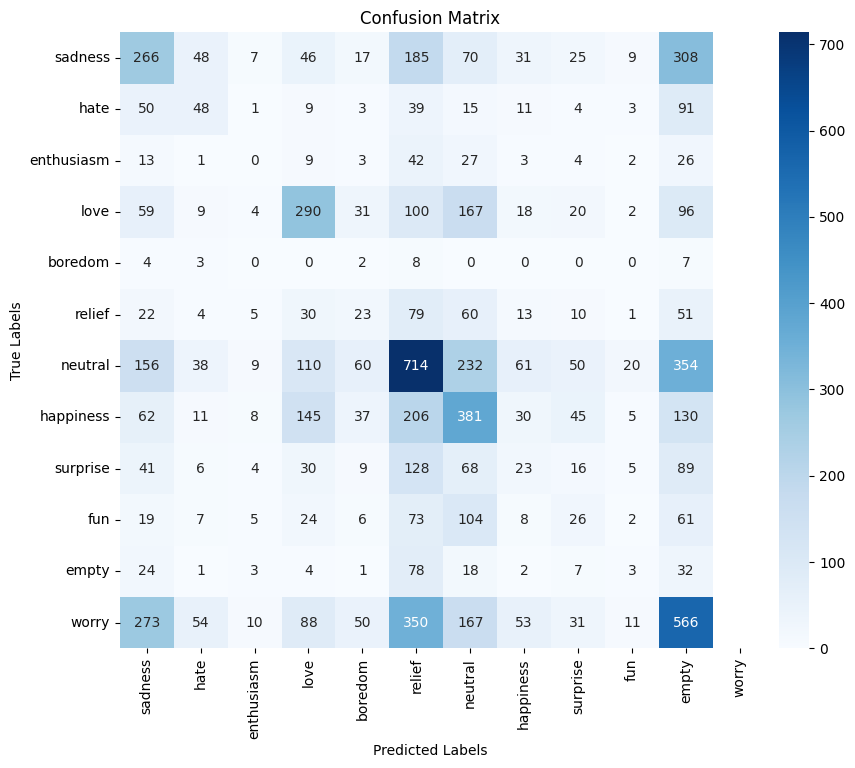

Classification Report (Micro Average):
              precision    recall  f1-score   support

     sadness       0.27      0.26      0.27      1012
        hate       0.21      0.18      0.19       274
  enthusiasm       0.00      0.00      0.00       130
        love       0.37      0.36      0.37       796
     boredom       0.00      0.00      0.00        24
      relief       0.10      0.08      0.09       298
     neutral       0.36      0.40      0.38      1804
   happiness       0.29      0.36      0.32      1060
    surprise       0.09      0.05      0.07       419
         fun       0.11      0.08      0.09       335
       empty       0.05      0.02      0.03       173
       worry       0.31      0.34      0.33      1653

    accuracy                           0.29      7978
   macro avg       0.18      0.18      0.18      7978
weighted avg       0.28      0.29      0.28      7978

Classification Report (Macro Average):
              precision    recall  f1-score   support



C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\berna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [6]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Generate predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Confusion matrix
cm = pd.crosstab(y_true_labels, y_pred_labels)
print("Confusion Matrix:")
print(cm)

# Classification report - Micro average
classification_report_micro = classification_report(y_true_labels, y_pred_labels, target_names=label_mapping.keys(), output_dict=False)

# Classification report - Macro average
classification_report_macro = classification_report(y_true_labels, y_pred_labels, target_names=label_mapping.keys(), output_dict=False)

print("Classification Report (Micro Average):")
print(classification_report_micro)
print("Classification Report (Macro Average):")
print(classification_report_macro)

# Generate heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report - Micro average
classification_report_micro = classification_report(y_true_labels, y_pred_labels, target_names=label_mapping.keys(), output_dict=False)

# Classification report - Macro average
classification_report_macro = classification_report(y_true_labels, y_pred_labels, target_names=label_mapping.keys(), output_dict=False)

print("Classification Report (Micro Average):")
print(classification_report_micro)
print("Classification Report (Macro Average):")
print(classification_report_macro)